## Plot results for catepillar tree

Mamie Wang 2020/10/14



Test run time and accuracy against the length of sequences for caterpillar tree of size 512. 

Scripts: `sbatch --array = `
List of experiments: `../test_catepillar_tree.lst`

In [3]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns
from matplotlib import cm

In [2]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import generation
import reconstruct_tree
import time
import utils
import pandas as pd
import argparse

# Find suitable parameters for caterpillar trees
tree_size = 512
tree = utils.lopsided_tree(tree_size)

In [14]:
m = 800
mutation_rate = 0.01
kappa = 2
observations, taxa_meta = generation.simulate_sequences(m, tree_model=tree, seq_model=generation.HKY(kappa = kappa), 
                                                        mutation_rate=mutation_rate, alphabet="DNA")


In [16]:
threshold = 64
spectral_method = reconstruct_tree.SpectralTreeReconstruction(reconstruct_tree.NeighborJoining, reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = spectral_method.deep_spectral_tree_reconstruction(observations, reconstruct_tree.HKY_similarity_matrix,
                                                            taxa_metadata = taxa_meta,
                                                            threshhold = threshold, min_split = 5, verbose = False)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)


64
--- 20.827547073364258 seconds ---
RF =  4
F1% =  99.80430528375734


In [17]:
nj = reconstruct_tree.NeighborJoining(reconstruct_tree.HKY_similarity_matrix)
start_time = time.time()
tree_rec = nj(observations, taxa_meta)
runtime = time.time() - start_time
RF,F1 = reconstruct_tree.compare_trees(tree_rec, tree)

if threshold is not None: print(threshold)
print("--- %s seconds ---" % runtime)
print("RF = ",RF)
print("F1% = ",F1)

64
--- 39.71326780319214 seconds ---
RF =  572
F1% =  72.01565557729941


In [51]:
# write out list of parameters to run

m = [400, 600, 800, 1000, 1200]
tree_type = "caterpillar"
method = ["NJ", "SNJ", "RAxML", 
          "STDR+NJ", "STDR+NJ", "STDR+NJ", 
          "STDR+SNJ", "STDR+SNJ", "STDR+SNJ", 
          "STDR+RAxML", "STDR+RAxML", "STDR+RAxML"]
nrun = 5
size = 512
path = "None"
threshold = [0] * 15 + list(np.repeat([256, 128, 64] * 3, 5))
kappa = 2
mutation_rate = 0.05
verbose = True
m_lst = np.tile(m, 12)

In [53]:
par_list = pd.DataFrame({"type": tree_type, "method": np.repeat(method, 5), 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m_lst, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [55]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_caterpillar_tree.lst", 
                sep = "\t",  index = False)

In [2]:
def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        perf_metrics.loc[:,"RF"] = perf_metrics.loc[:,"RF"] / (2 * 512 - 6)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

In [4]:
paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_m*")

metrics, summarized = summarize_perf(paths)
summarized

runtime            RF            F1      
                         mean     std  mean   std    mean   std
m    method                                                    
400  STDR+RAxML (64)    79.17    0.87  0.00  0.00  100.00  0.00
     STDR+RAxML (128)   90.77   12.31  0.00  0.00   99.98  0.04
     STDR+SNJ (64)      21.84    0.16  0.01  0.00   99.75  0.05
     STDR+SNJ (128)     24.09    0.95  0.01  0.01   99.41  0.25
     STDR+SNJ (256)     36.61    3.31  0.02  0.01   98.98  0.63
     SNJ               312.27   34.28  0.03  0.01   98.41  0.41
     STDR+NJ (64)       19.50    0.15  0.08  0.05   95.91  2.39
     STDR+RAxML (256)   96.97    7.58  0.18  0.05   90.82  2.48
     STDR+NJ (128)      23.66    0.31  0.39  0.07   80.57  3.42
     STDR+NJ (256)      25.14    0.26  0.72  0.05   64.27  2.29
     RAxML             163.49   57.62  0.76  0.08   62.23  3.79
     NJ                 42.70    0.23  0.95  0.05   52.60  2.31
600  STDR+SNJ (64)      24.78    0.54  0.00  0.00   99.96  0.05
     STDR+SNJ (128)     25.01    0.50  0.00  0.00   99.96  0.05
     STDR+SNJ (256)     41.36    2.05  0.00  0.00   99.96  0.09
     STDR+RAxML (64)   104.91    1.14  0.00  0.00  100.00  0.00
     SNJ               300.89   34.50  0.00  0.00   99.86  0.11
     STDR+NJ (64)       21.81    0.22  0.06  0.02   96.97  1.01
     STDR+RAxML (128)  113.66    8.36  0.06  0.09   96.91  4.25
     STDR+RAxML (256)  134.74    6.09  0.23  0.07   88.73  3.40
     STDR+NJ (128)      22.23    0.26  0.36  0.04   82.07  1.97
     STDR+NJ (256)      25.66    1.33  0.72  0.11   64.15  5.61
     RAxML             198.21   44.08  0.74  0.10   63.23  5.19
     NJ                 45.89    0.29  0.98  0.01   51.06  0.39
800  STDR+SNJ (64)      23.50    0.19  0.00  0.00  100.00  0.00
     STDR+SNJ (128)     26.70    0.68  0.00  0.00   99.98  0.04
     STDR+SNJ (256)     42.16    3.79  0.00  0.00   99.98  0.04
     STDR+RAxML (64)   132.19    1.94  0.00  0.00  100.00  0.00
     STDR+RAxML (128)  142.69    0.68  0.00  0.00  100.00  0.00
     SNJ               317.43   35.41  0.00  0.00   99.96  0.05
     STDR+NJ (64)       23.38    0.20  0.05  0.02   97.46  1.08
     STDR+RAxML (256)  172.79   50.27  0.22  0.06   88.88  2.92
     STDR+NJ (128)      25.72    0.19  0.36  0.02   82.29  0.81
     STDR+NJ (256)      26.61    0.32  0.70  0.05   65.19  2.38
     RAxML             298.18   75.20  0.81  0.11   59.90  5.63
     NJ                 44.83    1.73  0.99  0.00   50.82  0.16
1000 STDR+SNJ (64)      23.87    0.95  0.00  0.00  100.00  0.00
     STDR+SNJ (128)     27.07    1.19  0.00  0.00  100.00  0.00
     STDR+SNJ (256)     39.15    2.41  0.00  0.00  100.00  0.00
     STDR+RAxML (64)   160.12    1.84  0.00  0.00  100.00  0.00
     STDR+RAxML (128)  180.58   17.60  0.00  0.00  100.00  0.00
     SNJ               314.08   44.10  0.00  0.00  100.00  0.00
     STDR+NJ (64)       24.35    0.15  0.04  0.02   97.89  0.97
     STDR+RAxML (256)  214.34   50.40  0.09  0.13   95.40  6.35
     STDR+NJ (128)      24.50    0.24  0.30  0.03   85.24  1.26
     STDR+NJ (256)      24.15    0.82  0.67  0.07   66.71  3.34
     RAxML             344.57  105.06  0.75  0.10   62.52  5.16
     NJ                 47.70    0.18  0.94  0.06   52.95  3.01
1200 STDR+SNJ (64)      26.14    0.81  0.00  0.00  100.00  0.00
     STDR+SNJ (128)     29.45    1.44  0.00  0.00  100.00  0.00
     STDR+SNJ (256)     43.00    4.52  0.00  0.00  100.00  0.00
     STDR+RAxML (64)   184.28    3.25  0.00  0.00  100.00  0.00
     STDR+RAxML (128)  200.89    7.01  0.00  0.00  100.00  0.00
     SNJ               312.19   39.30  0.00  0.00  100.00  0.00
     STDR+NJ (64)       24.87    0.49  0.03  0.02   98.73  0.76
     STDR+RAxML (256)  280.30   74.87  0.15  0.14   92.74  7.00
     STDR+NJ (128)      26.68    0.45  0.31  0.04   84.79  2.19
     STDR+NJ (256)      26.99    1.15  0.70  0.09   65.26  4.35
     RAxML             412.91   78.43  0.82  0.05   59.06  2.55
     NJ                 47.22    1.50  0.99  0.01   50

In [4]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

In [88]:
ordering = ["RAxML", "STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", 
            "NJ", "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", 
            "SNJ", "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))

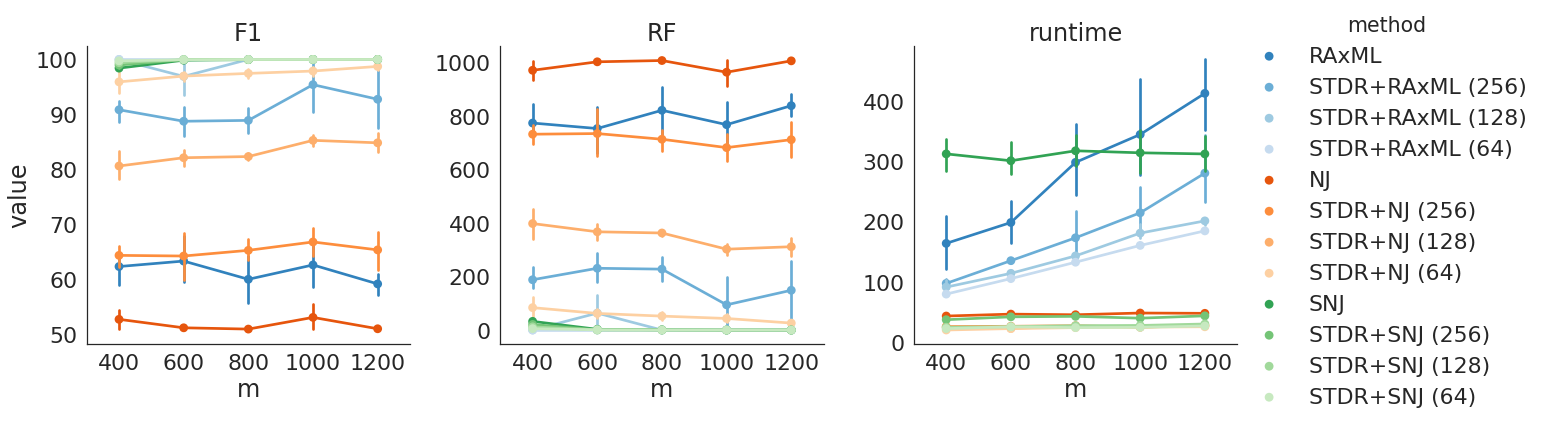

In [90]:
sns.set(style = "white", font_scale = 2)
sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = True, kind = "point", sharey = False, height = 6, palette = color_dict).set_titles("{col_name}")

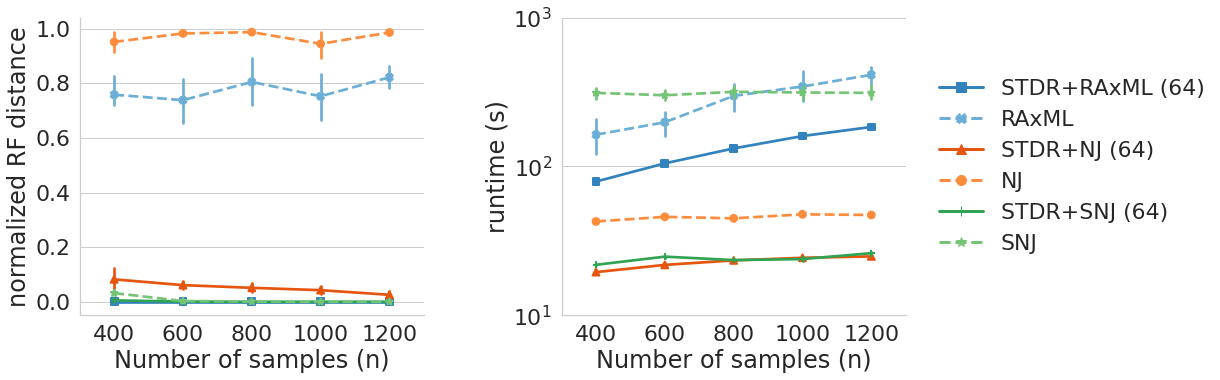

In [9]:
import glob
import pandas as pd
import re
from matplotlib import cm

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (64)", "RAxML", "STDR+NJ (64)","NJ",  "STDR+SNJ (64)", "SNJ"]

selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

markers = ["s", "X", "^", "o", "+", "*"]
color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))
linestyles = ["-", "--", "-", "--", "-", "--"]

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = False, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, markers = markers, linestyles=linestyles, 
                gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(10, 1000))
        ax.set_yticks([10,  10**2,  10**3], minor = False)
        
g.set_titles("")
g.set_xlabels("Number of samples (n)")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)

plt.subplots_adjust(wspace = 0.4)
plt.savefig("caterpillar_performance.eps", bbox_inches="tight")

## Using random walk laplacian

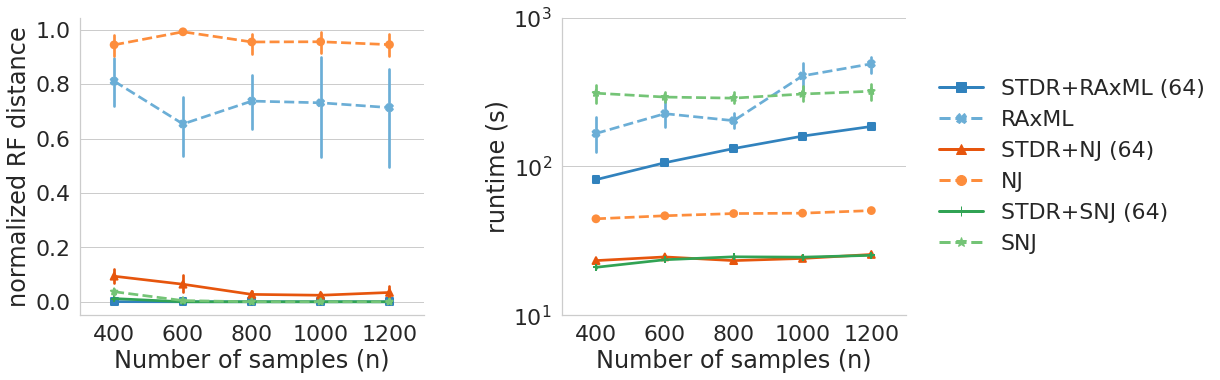

In [3]:
import glob
import pandas as pd
import re
from matplotlib import cm

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/caterpillar_rw_m*")
metrics, summarized = summarize_perf(paths)
summarized

df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (64)", "RAxML", "STDR+NJ (64)","NJ",  "STDR+SNJ (64)", "SNJ"]

selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

markers = ["s", "X", "^", "o", "+", "*"]
color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))
linestyles = ["-", "--", "-", "--", "-", "--"]

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", legend = False, kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, markers = markers, linestyles=linestyles, 
                gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(10, 1000))
        ax.set_yticks([10,  10**2,  10**3], minor = False)
        
g.set_titles("")
g.set_xlabels("Number of samples (n)")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)

plt.subplots_adjust(wspace = 0.4)
#plt.savefig("caterpillar_performance.eps", bbox_inches="tight")

In [4]:
summarized

runtime            RF            F1       
                         mean     std  mean   std    mean    std
m    method                                                     
400  STDR+RAxML (64)    81.54    0.53  0.00  0.00   99.98   0.04
     STDR+RAxML (128)   83.67    0.66  0.00  0.00  100.00   0.00
     STDR+SNJ (64)      21.01    0.33  0.01  0.00   99.41   0.20
     STDR+SNJ (128)     24.20    0.77  0.01  0.00   99.45   0.15
     STDR+SNJ (256)     38.58    4.10  0.01  0.00   99.28   0.23
     SNJ               310.78   55.85  0.04  0.02   98.16   0.77
     STDR+NJ (64)       23.32    0.10  0.09  0.03   95.32   1.65
     STDR+RAxML (256)  103.21   16.57  0.24  0.18   87.81   9.09
     STDR+NJ (128)      19.43    0.22  0.39  0.06   80.37   3.20
     STDR+NJ (256)      23.15    0.36  0.75  0.09   62.88   4.24
     RAxML             166.61   57.24  0.81  0.12   59.63   5.76
     NJ                 44.50    0.10  0.94  0.05   52.97   2.53
600  STDR+SNJ (64)      23.63    0.11  0.00  0.00  100.00   0.00
     STDR+SNJ (128)     25.47    0.56  0.00  0.00   99.96   0.09
     STDR+SNJ (256)     43.83    7.71  0.00  0.00   99.88   0.13
     STDR+RAxML (64)   105.98    1.71  0.00  0.00  100.00   0.00
     STDR+RAxML (128)  116.25    0.86  0.00  0.00  100.00   0.00
     SNJ               292.66   29.69  0.00  0.00   99.78   0.16
     STDR+NJ (64)       24.67    0.14  0.06  0.04   96.79   2.01
     STDR+RAxML (256)  147.75   31.37  0.25  0.21   87.61  10.43
     STDR+NJ (128)      24.02    0.22  0.40  0.08   80.29   3.74
     RAxML             226.39   63.50  0.65  0.13   67.46   6.43
     STDR+NJ (256)      26.01    0.40  0.68  0.04   66.22   2.10
     NJ                 46.65    0.27  0.99  0.00   50.59   0.18
800  STDR+SNJ (64)      24.72    0.21  0.00  0.00  100.00   0.00
     STDR+SNJ (128)     28.00    0.82  0.00  0.00  100.00   0.00
     STDR+SNJ (256)     40.71    1.81  0.00  0.00   99.98   0.04
     STDR+RAxML (64)   131.96    1.92  0.00  0.00  100.00   0.00
     STDR+RAxML (128)  145.26    1.81  0.00  0.00  100.00   0.00
     SNJ               287.85   31.59  0.00  0.00  100.00   0.00
     STDR+NJ (64)       23.30    0.13  0.03  0.02   98.65   0.80
     STDR+RAxML (256)  182.94   29.97  0.17  0.16   91.45   7.98
     STDR+NJ (128)      25.01    0.13  0.34  0.01   83.27   0.62
     STDR+NJ (256)      28.55    0.23  0.68  0.08   66.26   3.91
     RAxML             203.11   27.50  0.74  0.13   63.27   6.35
     NJ                 48.26    0.32  0.95  0.05   52.45   2.37
1000 STDR+SNJ (64)      24.59    0.25  0.00  0.00  100.00   0.00
     STDR+SNJ (128)     27.41    1.14  0.00  0.00  100.00   0.00
     STDR+SNJ (256)     41.48    3.26  0.00  0.00  100.00   0.00
     STDR+RAxML (64)   159.93    1.89  0.00  0.00  100.00   0.00
     STDR+RAxML (128)  177.66    9.46  0.00  0.00  100.00   0.00
     SNJ               306.71   48.01  0.00  0.00  100.00   0.00
     STDR+NJ (64)       24.10    0.15  0.02  0.01   98.81   0.54
     STDR+NJ (128)      25.00    0.17  0.26  0.05   86.91   2.47
     STDR+RAxML (256)  212.10   18.13  0.37  0.10   81.39   4.94
     STDR+NJ (256)      28.56    0.22  0.66  0.04   67.05   2.07
     RAxML             406.32  110.84  0.73  0.24   63.58  11.79
     NJ                 48.54    0.18  0.96  0.05   52.41   2.45
1200 STDR+SNJ (64)      25.29    0.48  0.00  0.00  100.00   0.00
     STDR+SNJ (128)     27.66    0.35  0.00  0.00  100.00   0.00
     STDR+SNJ (256)     43.24    4.15  0.00  0.00  100.00   0.00
     STDR+RAxML (64)   185.73    1.97  0.00  0.00  100.00   0.00
     STDR+RAxML (128)  203.15    1.71  0.00  0.00  100.00   0.00
     SNJ               320.25   50.27  0.00  0.00  100.00   0.00
     STDR+NJ (64)       25.63    0.43  0.03  0.03   98.30   1.57
     STDR+RAxML (256)  253.98   38.61  0.19  0.13   90.47   6.31
     STDR+NJ (128)      25.54    0.18  0.33  0.06   83.68   2.77
     STDR+NJ (256)      28.62    0.66  0.65  0.05   67.75   2.41
     RAxML             489.46   77.76  0.71  0.23   64.46